<a href="https://colab.research.google.com/github/isshii/de4test/blob/master/DeepExplorer/VGG16_Lime_to_DeepExplorer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from keras_applications.imagenet_utils import preprocess_input as preprocess_input
import os, re
import random
import keras
# models
from keras.applications import inception_v3 as inc_net
from keras.applications import resnet50 as resnet50
from keras.applications import vgg16 as vgg16
from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras.applications.resnet50 import ResNet50
#from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions
from keras.layers import Input
from keras.preprocessing import image

from skimage.segmentation import mark_boundaries
from skimage.io import imread
import matplotlib.pyplot as plt
import numpy as np
print('Notebook run using keras:', keras.__version__)

import argparse
import imageio

Using TensorFlow backend.


Notebook run using keras: 2.2.5


In [0]:
# 共通で使うパスなどの定義
# 共通の変数設定
# 共通フォルダパス
data_dir = "/content/gdrive/My Drive/ColabNotebooks/test4ai/data"
data_imagenet = "/content/gdrive/My Drive/ColabNotebooks/test4ai/data/ImageNet"
data_imagenet_seeds = "/content/gdrive/My Drive/ColabNotebooks/test4ai/data/ImageNet/seeds"
data_imagenet_single = "/content/gdrive/My Drive/ColabNotebooks/test4ai/data/ImageNet/single"
model_dir = "/content/gdrive/My Drive/ColabNotebooks/test4ai/model"
output_dir = "/content/gdrive/My Drive/ColabNotebooks/test4ai/output"
tmp_dir = "/content/gdrive/My Drive/ColabNotebooks/test4ai/tmp"

In [3]:
# ドライブをマウントする
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
# outputフォルダ内容物のクリーンアップ削除
!rm "$output_dir"/*

rm: cannot remove '/content/gdrive/My Drive/ColabNotebooks/test4ai/output/*': No such file or directory


In [5]:
#lime  インストール
! pip install lime
%load_ext autoreload
%autoreload 2
import os,sys
try:
    import lime
except:
    sys.path.append(os.path.join('..', '..')) # add the current directory
    import lime
from lime import lime_image

In [0]:
# 画像読み込みユーティリティ
def transform_img_fn(path_list, target_size=(299, 299)):
    out = []
    for img_path in path_list:
        img = image.load_img(img_path, target_size=target_size)
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = vgg16.preprocess_input(x, mode='tf')
        out.append(x)
    return np.vstack(out)

def load_image(filename):
  img = image.load_img(filename, target_size=(224, 224))
  return image.img_to_array(img)

In [0]:
def get_predicts(model, imgpath):
  images4vgg = [imgpath]
  x = np.zeros((len(images4vgg), 224, 224, 3))

  for i in range(0, len(images4vgg)):
    x[i] = load_image(images4vgg[i])
  pred = model.predict(preprocess_input(x))
  #print('pred.shape={shape}'.format(shape=pred.shape))
  top = decode_predictions(pred, top=5)

  for i in range(0, len(top)):
    #print('{i}:'.format(i=i))
    for j in range(0, len(top[i])):
      name, desc, score = top[i][j]
      #print('  {rank}    {desc} {score:02.1f}%'.format(rank=j+1, desc=desc, score=score*100))
  
  return model.predict


In [0]:
# lime の出力 (mask の結果) を DeepExplorer のノイズブロックの位置に使えるように変換する
# 特定サイズの矩形で、最も1(maskされている=limeによって特徴的であると判断された場所)が含まれる個数が多い場所を求める
# 評価が同じ矩形が複数あった場合は最初のひとつを保持する
def get_rectangle_good_2_noise(nparray, rectangle_size=(30, 30)):
    max_x = 0
    max_y = 0
    max_score = 0
    sizeof_x = len(nparray[0])
    sizeof_y = len(nparray)
    #print(len(nparray[0]))
    #print(len(nparray))
    for y in range(0, sizeof_y):
        for x in range(0, sizeof_x):
            fixed_y = y+rectangle_size[0]
            fixed_x = x+rectangle_size[1]
            score = np.sum(nparray[y:fixed_y, x:fixed_x])
            #print(image[y:fixed_y, x:fixed_x])
            #print("x:%d  y:%d" % (x, y))
            #print("score: %d" % score)
            #print("")
            if score > max_score:
                max_x = x
                max_y = y
                max_score = score
    #print("max score : %d" % max_score)
    #print("rectangle x : %d  y : %d" % (max_x, max_y))
    return (max_x, max_y, max_score)

# lime 用の 4角マスクデータを作るよ
def create_my_mask(target_size=(224,224), x_start=0, y_start=0, rectangle_size=(30, 30)):
  my_mask = np.zeros(target_size, dtype = int)
  x_end = x_start + rectangle_size[0]
  y_end = y_start + rectangle_size[1]
  my_mask[y_start:y_end, x_start:x_end]=1
  return my_mask

In [0]:
# lime よんで mask とって de 用のノイズ位置をゲットするよ
def get_rectangle_using_lime_result(model, imgpath, target_block_size=(60,60)):
  # lime による特徴ピクセル取得 
  explainer = lime_image.LimeImageExplainer()
  image_to_lime =  transform_img_fn([imgpath], (224, 224))[0]
  explanation = explainer.explain_instance(image_to_lime, get_predicts(model, imgpath), top_labels=5, hide_color=0, num_samples=1000)
  temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=1, hide_rest=False)
  # LIME の素の出力を見たいときには↓をアンコメントしてね
  # plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

  (start_x, start_y, score) = get_rectangle_good_2_noise(mask, target_block_size)
  my_mask = create_my_mask((224, 224), start_x, start_y, target_block_size)
  
  # DeepExplorer 向けのブロックノイズ位置の出力
  np.set_printoptions(threshold=224*224)
  temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=1, hide_rest=False)
  # LIME の素の出力をしたいときには↓をアンコメントしてね
  #plt.imshow(mark_boundaries(temp / 2 + 0.5, my_mask))

  return (start_x, start_y)

In [0]:
# 指定されたフォルダ内の画像っぽいファイルのパスリストを返す
def list_pictures(directory, ext='jpg|jpeg|bmp|png|ppm'):
    return [os.path.join(root, f)
            for root, _, files in os.walk(directory) for f in files
            if re.match(r'([\w]+\.(?:' + ext + '))', f.lower())]

1/50 : ILSVRC2012_test_00001926.JPEG : (62, 135)


2/50 : ILSVRC2012_test_00001869.JPEG : (67, 137)


3/50 : ILSVRC2012_test_00001733.JPEG : (71, 43)


4/50 : ILSVRC2012_test_00001567.JPEG : (77, 122)


5/50 : ILSVRC2012_test_00001739.JPEG : (0, 164)


6/50 : ILSVRC2012_test_00001810.JPEG : (136, 86)


7/50 : ILSVRC2012_test_00001288.JPEG : (164, 0)


8/50 : ILSVRC2012_test_00001514.JPEG : (164, 145)


9/50 : ILSVRC2012_test_00001490.JPEG : (97, 0)


10/50 : ILSVRC2012_test_00001902.JPEG : (104, 43)


11/50 : ILSVRC2012_test_00001549.JPEG : (104, 55)


12/50 : ILSVRC2012_test_00001955.JPEG : (0, 80)


13/50 : ILSVRC2012_test_00001351.JPEG : (118, 5)


14/50 : ILSVRC2012_test_00001422.JPEG : (137, 118)


15/50 : ILSVRC2012_test_00001685.JPEG : (121, 23)


16/50 : ILSVRC2012_test_00001428.JPEG : (16, 73)


17/50 : ILSVRC2012_test_00001526.JPEG : (140, 20)


18/50 : ILSVRC2012_test_00001778.JPEG : (29, 164)


19/50 : ILSVRC2012_test_00001543.JPEG : (72, 90)


20/50 : ILSVRC2012_test_00001886.JPEG : (141, 75)


21/50 : ILSVRC2012_test_00001949.JPEG : (117, 17)


22/50 : ILSVRC2012_test_00001699.JPEG : (164, 23)


23/50 : ILSVRC2012_test_00001676.JPEG : (0, 57)


24/50 : ILSVRC2012_test_00001930.JPEG : (21, 164)


25/50 : ILSVRC2012_test_00001390.JPEG : (123, 0)


26/50 : ILSVRC2012_test_00001530.JPEG : (164, 164)


27/50 : ILSVRC2012_test_00001796.JPEG : (118, 164)


28/50 : ILSVRC2012_test_00001847.JPEG : (99, 54)


29/50 : ILSVRC2012_test_00001834.JPEG : (16, 68)


30/50 : ILSVRC2012_test_00001469.JPEG : (44, 164)


31/50 : ILSVRC2012_test_00001582.JPEG : (60, 70)


32/50 : ILSVRC2012_test_00001475.JPEG : (70, 164)


33/50 : ILSVRC2012_test_00001619.JPEG : (47, 25)


34/50 : ILSVRC2012_test_00001644.JPEG : (29, 156)


35/50 : ILSVRC2012_test_00001375.JPEG : (54, 70)


36/50 : ILSVRC2012_test_00001725.JPEG : (56, 164)


37/50 : ILSVRC2012_test_00001701.JPEG : (80, 164)


38/50 : ILSVRC2012_test_00001772.JPEG : (88, 87)


39/50 : ILSVRC2012_test_00001306.JPEG : (62, 109)


40/50 : ILSVRC2012_test_00001660.JPEG : (164, 0)


41/50 : ILSVRC2012_test_00001451.JPEG : (141, 12)


42/50 : ILSVRC2012_test_00001613.JPEG : (0, 85)


43/50 : ILSVRC2012_test_00001369.JPEG : (119, 119)


44/50 : ILSVRC2012_test_00001588.JPEG : (164, 164)


45/50 : ILSVRC2012_test_00001890.JPEG : (164, 164)


46/50 : ILSVRC2012_test_00001637.JPEG : (0, 135)


47/50 : ILSVRC2012_test_00001863.JPEG : (123, 4)


48/50 : ILSVRC2012_test_00001797.JPEG : (164, 164)


49/50 : ILSVRC2012_test_00001756.JPEG : (0, 164)


50/50 : ILSVRC2012_test_00001322.JPEG : (0, 36)
CPU times: user 3min 49s, sys: 27.8 s, total: 4min 17s
Wall time: 7min 56s


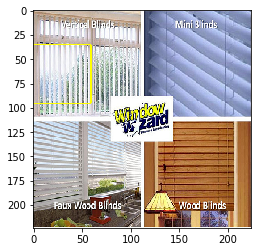

In [42]:
%%time

# 画像ごとの DeepXplorer 用ブロックノイズの始点データの入れ物
# basename : (start_x, start_y)
xydict = {}

# VGG16 による画像のラベル判定(LIME 適用準備)
vgg16_model = vgg16.VGG16(include_top=True, weights='imagenet', input_tensor=None, input_shape=None)

# 画像読み込み
#imgpath = "/content/gdrive/My Drive/ColabNotebooks/test4ai/data/ImageNet/single/ILSVRC2012_test_00001582.JPEG"
#imgpath =  "/content/gdrive/My Drive/ColabNotebooks/test4ai/data/ImageNet/seeds/ILSVRC2012_test_00001288.JPEG"

img_path_list = list_pictures(data_imagenet_seeds)

i = 0
numimg = len(img_path_list)
for imgpath in img_path_list:
  imgpath_basename = os.path.basename(imgpath)
  x_and_y = get_rectangle_using_lime_result(vgg16_model, imgpath)
  i = i + 1
  print(f'{i}/{numimg} : {imgpath_basename} : {x_and_y}')
  xydict[imgpath_basename] = x_and_y

# xydict を yaml で保存
import yaml

with open("/content/gdrive/My Drive/ColabNotebooks/test4ai/output/xydict.yaml", "w") as wf:
    yaml.dump(xydict, wf)



In [45]:
with open("/content/gdrive/My Drive/ColabNotebooks/test4ai/output/xydict.yaml") as rf:
    data = yaml.load(rf)

for d in data:
  print(f'{d} : {data[d]}')

ILSVRC2012_test_00001288.JPEG : (164, 0)
ILSVRC2012_test_00001306.JPEG : (62, 109)
ILSVRC2012_test_00001322.JPEG : (0, 36)
ILSVRC2012_test_00001351.JPEG : (118, 5)
ILSVRC2012_test_00001369.JPEG : (119, 119)
ILSVRC2012_test_00001375.JPEG : (54, 70)
ILSVRC2012_test_00001390.JPEG : (123, 0)
ILSVRC2012_test_00001422.JPEG : (137, 118)
ILSVRC2012_test_00001428.JPEG : (16, 73)
ILSVRC2012_test_00001451.JPEG : (141, 12)
ILSVRC2012_test_00001469.JPEG : (44, 164)
ILSVRC2012_test_00001475.JPEG : (70, 164)
ILSVRC2012_test_00001490.JPEG : (97, 0)
ILSVRC2012_test_00001514.JPEG : (164, 145)
ILSVRC2012_test_00001526.JPEG : (140, 20)
ILSVRC2012_test_00001530.JPEG : (164, 164)
ILSVRC2012_test_00001543.JPEG : (72, 90)
ILSVRC2012_test_00001549.JPEG : (104, 55)
ILSVRC2012_test_00001567.JPEG : (77, 122)
ILSVRC2012_test_00001582.JPEG : (60, 70)
ILSVRC2012_test_00001588.JPEG : (164, 164)
ILSVRC2012_test_00001613.JPEG : (0, 85)
ILSVRC2012_test_00001619.JPEG : (47, 25)
ILSVRC2012_test_00001637.JPEG : (0, 135)
IL

In [0]:
# ここまで lime 実行〜出力を DeepExplorer で利用できるようにする準備
# ここから DeepExplorer の実行

In [15]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 7180771703530904480, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 9456726960224049637
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 3196645796738867377
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14912199066
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 11075573376061901039
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"]

In [15]:
#@title パラメータ
variable_name = "" #@param {type:"string"}
# DeepXplore のパラメータ設定部
# read the parameter
# argument parsing
parser = argparse.ArgumentParser(description='Main function for difference-inducing input generation in MNIST dataset')
parser.add_argument('transformation', help="realistic transformation type", choices=['light', 'occl', 'blackout'])
parser.add_argument('weight_diff', help="weight hyperparm to control differential behavior", type=float)
parser.add_argument('weight_nc', help="weight hyperparm to control neuron coverage", type=float)
parser.add_argument('step', help="step size of gradient descent", type=float)
parser.add_argument('seeds', help="number of seeds of input", type=int)
parser.add_argument('grad_iterations', help="number of iterations of gradient descent", type=int)
parser.add_argument('threshold', help="threshold for determining neuron activated", type=float)
parser.add_argument('-t', '--target_model', help="target model that we want it predicts differently",
                    choices=[0, 1, 2], default=0, type=int)
parser.add_argument('-sp', '--start_point', help="occlusion upper left corner coordinate", default=(start_y, start_x), type=tuple)
parser.add_argument('-occl_size', '--occlusion_size', help="occlusion size", default=target_block_size, type=tuple)

_StoreAction(option_strings=['-occl_size', '--occlusion_size'], dest='occlusion_size', nargs=None, const=None, default=(60, 60), type=<class 'tuple'>, choices=None, help='occlusion size', metavar=None)

In [0]:
#@title ノイズのタイプ light / occl / blackout
#@body {light,occl,blackout} weight_diff weight_nc step seeds
#                   grad_iterations threshold
noise_type = "occl" #@param ["light", "occl", "blackout"]
weight_diff = "0.1" #@param {type:"string"}
weight_nc = "0.1" #@param {type:"string"}
step = "1" #@param {type:"string"}
seeds = "10" #@param {type:"string"}
grad_iterations = "100" #@param {type:"string"}
threshold = "0.1" #@param {type:"string"}

In [0]:
args = parser.parse_args([noise_type, weight_diff, weight_nc, step, seeds, grad_iterations, threshold])


In [0]:
import random
from collections import defaultdict

import numpy as np
from keras import backend as K
from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras.models import Model
from keras.preprocessing import image
import os, re


def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    input_img_data = image.img_to_array(img)
    input_img_data = np.expand_dims(input_img_data, axis=0)
    input_img_data = preprocess_input(input_img_data)  # final input shape = (1,224,224,3)
    return input_img_data


def deprocess_image(x):
    x = x.reshape((224, 224, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x


def decode_label(pred):
    return decode_predictions(pred)[0][0][1]


def normalize(x):
    # utility function to normalize a tensor by its L2 norm
    return x / (K.sqrt(K.mean(K.square(x))) + 1e-5)


def constraint_occl(gradients, start_point, rect_shape):
    new_grads = np.zeros_like(gradients)
    new_grads[:, start_point[0]:start_point[0] + rect_shape[0],
    start_point[1]:start_point[1] + rect_shape[1]] = gradients[:, start_point[0]:start_point[0] + rect_shape[0],
                                                     start_point[1]:start_point[1] + rect_shape[1]]
    return new_grads


def constraint_light(gradients):
    new_grads = np.ones_like(gradients)
    grad_mean = 1e4 * np.mean(gradients)
    return grad_mean * new_grads


def constraint_black(gradients, rect_shape=(10, 10)):
    start_point = (
        random.randint(0, gradients.shape[1] - rect_shape[0]), random.randint(0, gradients.shape[2] - rect_shape[1]))
    new_grads = np.zeros_like(gradients)
    patch = gradients[:, start_point[0]:start_point[0] + rect_shape[0], start_point[1]:start_point[1] + rect_shape[1]]
    if np.mean(patch) < 0:
        new_grads[:, start_point[0]:start_point[0] + rect_shape[0],
        start_point[1]:start_point[1] + rect_shape[1]] = -np.ones_like(patch)
    return new_grads


def init_coverage_tables(model1, model2, model3):
    model_layer_dict1 = defaultdict(bool)
    model_layer_dict2 = defaultdict(bool)
    model_layer_dict3 = defaultdict(bool)
    init_dict(model1, model_layer_dict1)
    init_dict(model2, model_layer_dict2)
    init_dict(model3, model_layer_dict3)
    return model_layer_dict1, model_layer_dict2, model_layer_dict3


def init_dict(model, model_layer_dict):
    for layer in model.layers:
        if 'flatten' in layer.name or 'input' in layer.name:
            continue
        for index in range(layer.output_shape[-1]):
            model_layer_dict[(layer.name, index)] = False


def neuron_to_cover(model_layer_dict):
    not_covered = [(layer_name, index) for (layer_name, index), v in list(model_layer_dict.items()) if not v]
    if not_covered:
        layer_name, index = random.choice(not_covered)
    else:
        layer_name, index = random.choice(list(model_layer_dict.keys()))
    return layer_name, index


def neuron_covered(model_layer_dict):
    covered_neurons = len([v for v in list(model_layer_dict.values()) if v])
    total_neurons = len(model_layer_dict)
    return covered_neurons, total_neurons, covered_neurons / float(total_neurons)


def scale(intermediate_layer_output, rmax=1, rmin=0):
    X_std = (intermediate_layer_output - intermediate_layer_output.min()) / (
        intermediate_layer_output.max() - intermediate_layer_output.min())
    X_scaled = X_std * (rmax - rmin) + rmin
    return X_scaled


def update_coverage(input_data, model, model_layer_dict, threshold=0):
    layer_names = [layer.name for layer in model.layers if
                   'flatten' not in layer.name and 'input' not in layer.name]

    intermediate_layer_model = Model(inputs=model.input,
                                     outputs=[model.get_layer(layer_name).output for layer_name in layer_names])
    intermediate_layer_outputs = intermediate_layer_model.predict(input_data)

    for i, intermediate_layer_output in enumerate(intermediate_layer_outputs):
        scaled = scale(intermediate_layer_output[0])
        for num_neuron in range(scaled.shape[-1]):
            if np.mean(scaled[..., num_neuron]) > threshold and not model_layer_dict[(layer_names[i], num_neuron)]:
                model_layer_dict[(layer_names[i], num_neuron)] = True


def full_coverage(model_layer_dict):
    if False in list(model_layer_dict.values()):
        return False
    return True


def fired(model, layer_name, index, input_data, threshold=0):
    intermediate_layer_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
    intermediate_layer_output = intermediate_layer_model.predict(input_data)[0]
    scaled = scale(intermediate_layer_output)
    if np.mean(scaled[..., index]) > threshold:
        return True
    return False


def diverged(predictions1, predictions2, predictions3, target):
    if not predictions1 == predictions2 == predictions3:
        return True
    return False

#add
def list_pictures(directory, ext='jpg|jpeg|bmp|png|ppm'):
    return [os.path.join(root, f)
            for root, _, files in os.walk(directory) for f in files
            if re.match(r'([\w]+\.(?:' + ext + '))', f.lower())]

In [19]:
%%time
# input image dimensions
img_rows, img_cols = 224, 224
input_shape = (img_rows, img_cols, 3)

# define input tensor as a placeholder
input_tensor = Input(shape=input_shape)

# load multiple models sharing same input tensor
K.set_learning_phase(0)

model1 = vgg16.VGG16(input_tensor=input_tensor)
model2 = VGG19(input_tensor=input_tensor)
model3 = ResNet50(input_tensor=input_tensor)


# init coverage table
model_layer_dict1, model_layer_dict2, model_layer_dict3 = init_coverage_tables(model1, model2, model3)



CPU times: user 9.31 s, sys: 628 ms, total: 9.94 s
Wall time: 9.91 s


In [0]:
# start gen inputs
 img_paths = list_pictures(data_imagenet_single)

In [21]:
%%time
for _ in range(args.seeds):
    gen_img = preprocess_image(random.choice(img_paths))
    orig_img = gen_img.copy()
    # first check if input already induces differences
    pred1, pred2, pred3 = model1.predict(gen_img), model2.predict(gen_img), model3.predict(gen_img)
    label1, label2, label3 = np.argmax(pred1[0]), np.argmax(pred2[0]), np.argmax(pred3[0])
    if not label1 == label2 == label3:
        print('input already causes different outputs: {}, {}, {}'.format(decode_label(pred1),
                                                                                            decode_label(pred2),
                                                                                            decode_label(
                                                                                                pred3)))

        update_coverage(gen_img, model1, model_layer_dict1, args.threshold)
        update_coverage(gen_img, model2, model_layer_dict2, args.threshold)
        update_coverage(gen_img, model3, model_layer_dict3, args.threshold)

        print('covered neurons percentage %d neurons %.3f, %d neurons %.3f, %d neurons %.3f'
              % (len(model_layer_dict1), neuron_covered(model_layer_dict1)[2], len(model_layer_dict2),
                 neuron_covered(model_layer_dict2)[2], len(model_layer_dict3),
                 neuron_covered(model_layer_dict3)[2]))
  
        averaged_nc = (neuron_covered(model_layer_dict1)[0] + neuron_covered(model_layer_dict2)[0] +
                       neuron_covered(model_layer_dict3)[0]) / float(
            neuron_covered(model_layer_dict1)[1] + neuron_covered(model_layer_dict2)[1] +
            neuron_covered(model_layer_dict3)[1])
        print('averaged covered neurons %.3f' % averaged_nc)

        gen_img_deprocessed = deprocess_image(gen_img)

        # save the result to disk
        outputfilepath0 = os.path.join(output_dir, 'already_differ_' + decode_label(pred1) + '_' + decode_label(pred2) + '_' + decode_label(pred3) + '.png')
        imageio.imwrite(outputfilepath0, gen_img_deprocessed)
        continue

    # if all label agrees
    orig_label = label1
    layer_name1, index1 = neuron_to_cover(model_layer_dict1)
    layer_name2, index2 = neuron_to_cover(model_layer_dict2)
    layer_name3, index3 = neuron_to_cover(model_layer_dict3)

    # construct joint loss function
    if args.target_model == 0:
        loss1 = -args.weight_diff * K.mean(model1.get_layer('predictions').output[..., orig_label])
        loss2 = K.mean(model2.get_layer('predictions').output[..., orig_label])
        loss3 = K.mean(model3.get_layer('fc1000').output[..., orig_label])
    elif args.target_model == 1:
        loss1 = K.mean(model1.get_layer('predictions').output[..., orig_label])
        loss2 = -args.weight_diff * K.mean(model2.get_layer('predictions').output[..., orig_label])
        loss3 = K.mean(model3.get_layer('fc1000').output[..., orig_label])
    elif args.target_model == 2:
        loss1 = K.mean(model1.get_layer('predictions').output[..., label1])
        loss2 = K.mean(model2.get_layer('predictions').output[..., orig_label])
        loss3 = -args.weight_diff * K.mean(model3.get_layer('fc1000').output[..., orig_label])
    loss1_neuron = K.mean(model1.get_layer(layer_name1).output[..., index1])
    loss2_neuron = K.mean(model2.get_layer(layer_name2).output[..., index2])
    loss3_neuron = K.mean(model3.get_layer(layer_name3).output[..., index3])
    layer_output = (loss1 + loss2 + loss3) + args.weight_nc * (loss1_neuron + loss2_neuron + loss3_neuron)

    # for adversarial image generation
    final_loss = K.mean(layer_output)

    # we compute the gradient of the input picture wrt this loss
    grads = normalize(K.gradients(final_loss, input_tensor)[0])

    # this function returns the loss and grads given the input picture
    iterate = K.function([input_tensor], [loss1, loss2, loss3, loss1_neuron, loss2_neuron, loss3_neuron, grads])

    # we run gradient ascent for 20 steps
    for iters in range(args.grad_iterations):
        loss_value1, loss_value2, loss_value3, loss_neuron1, loss_neuron2, loss_neuron3, grads_value = iterate(
            [gen_img])
        if args.transformation == 'light':
            grads_value = constraint_light(grads_value)  # constraint the gradients value
        elif args.transformation == 'occl':
            grads_value = constraint_occl(grads_value, args.start_point,
                                          args.occlusion_size)  # constraint the gradients value
        elif args.transformation == 'blackout':
            grads_value = constraint_black(grads_value)  # constraint the gradients value

        gen_img += grads_value * args.step
        pred1, pred2, pred3 = model1.predict(gen_img), model2.predict(gen_img), model3.predict(gen_img)
        label1, label2, label3 = np.argmax(pred1[0]), np.argmax(pred2[0]), np.argmax(pred3[0])

        if not label1 == label2 == label3:
            update_coverage(gen_img, model1, model_layer_dict1, args.threshold)
            update_coverage(gen_img, model2, model_layer_dict2, args.threshold)
            update_coverage(gen_img, model3, model_layer_dict3, args.threshold)
            averaged_nc = (neuron_covered(model_layer_dict1)[0] + neuron_covered(model_layer_dict2)[0] +
                           neuron_covered(model_layer_dict3)[0]) / float(
                neuron_covered(model_layer_dict1)[1] + neuron_covered(model_layer_dict2)[1] +
                neuron_covered(model_layer_dict3)[
                    1])
            print('averaged covered neurons %.3f' % averaged_nc)

            gen_img_deprocessed = deprocess_image(gen_img)
            orig_img_deprocessed = deprocess_image(orig_img)

            # save the result to disk
            outputfilepath = os.path.join(output_dir, args.transformation + '_' + decode_label(pred1) + '_' + decode_label(pred2) + '_' + decode_label(pred3) + '.png')
            print(outputfilepath)
            imageio.imwrite(outputfilepath, gen_img_deprocessed)
            outputfilepath2 = os.path.join(output_dir, args.transformation + '_' + decode_label(pred1) + '_' + decode_label(pred2) + '_' + decode_label(pred3) + '_orig.png')
            print(outputfilepath2)
            imageio.imwrite(outputfilepath2, orig_img_deprocessed)
            break

averaged covered neurons 0.578
/content/gdrive/My Drive/ColabNotebooks/test4ai/output/occl_African_chameleon_lacewing_African_chameleon.png
/content/gdrive/My Drive/ColabNotebooks/test4ai/output/occl_African_chameleon_lacewing_African_chameleon_orig.png
averaged covered neurons 0.588
/content/gdrive/My Drive/ColabNotebooks/test4ai/output/occl_green_lizard_African_chameleon_African_chameleon.png
/content/gdrive/My Drive/ColabNotebooks/test4ai/output/occl_green_lizard_African_chameleon_African_chameleon_orig.png
averaged covered neurons 0.596
/content/gdrive/My Drive/ColabNotebooks/test4ai/output/occl_lacewing_African_chameleon_African_chameleon.png
/content/gdrive/My Drive/ColabNotebooks/test4ai/output/occl_lacewing_African_chameleon_African_chameleon_orig.png
averaged covered neurons 0.602
/content/gdrive/My Drive/ColabNotebooks/test4ai/output/occl_African_chameleon_lacewing_African_chameleon.png
/content/gdrive/My Drive/ColabNotebooks/test4ai/output/occl_African_chameleon_lacewing_Afr